In [1]:
import pandas as pd

In [2]:
# Here I Loaded  the datasets
df1 = pd.read_excel("/content/Claim_Verification_English_Train.xlsx")
df2 = pd.read_excel("/content/Claim_Verification_Telugu_Train.xlsx")

In [3]:
#  Here I concatenated the datasets
df = pd.concat([df1, df2])
#df = df2
#df = df1


In [4]:
# Here I used df.info to know information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24650 entries, 0 to 12324
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Statement  24650 non-null  object
 1   Label      24650 non-null  object
 2   Category   24650 non-null  object
dtypes: object(3)
memory usage: 770.3+ KB


In [5]:
df['Label'] = df['Label'].astype(str)

In [6]:
#  Here I used sk-learn to Convert the labels to numbers
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['Label'] = le.fit_transform(df.Label.values)

In [7]:
# Here, I shuffeled the dataframe
from sklearn.utils import shuffle
df = shuffle(df)

In [8]:
#Here I am counting the fake and valid labels.
True_labels = (df['Label'] == 1).sum()
fake_labels = (df['Label'] == 0).sum()
print(f"Number of True labels: {True_labels}")
print(f"Number of Fake labels: {fake_labels}")

Number of True labels: 12320
Number of Fake labels: 12330


In [9]:
#  Here, I Split the data into training and validation splits
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels_str, val_labels_str = train_test_split(list(df['Statement']), list(df['Label']), test_size=.2)

In [10]:
# Here I Installed the required packages
!pip install sentencepiece
!pip install transformers
!pip install transformers accelerate
!pip install torch==1.11.00.676617

ERROR: Could not find a version that satisfies the requirement torch==1.11.00.676617 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1)
ERROR: No matching distribution found for torch==1.11.00.676617


In [11]:
# # Here I loaded Bert tokenizer and MBERT model
from transformers import BertTokenizer, BertModel
import torch
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [12]:
# Here, I tokenized the texts and finetuned them on the dataset
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

In [13]:
# Here I created claim verification dataset
class Claim_verification_Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [14]:
#  Here I encoded the data labels
train_labels = le.fit_transform(train_labels_str)
val_labels = le.transform(val_labels_str)

# Here I created the dataset objects
train_dataset = Claim_verification_Dataset(train_encodings, train_labels)
val_dataset = Claim_verification_Dataset(val_encodings, val_labels)

In [15]:
# I used an additional classiffication layer on top of my MBERT for this specific task
import torch.nn as nn

class Classification_layer(nn.Module):
    def __init__(self, model_name, num_labels):
        super(Classification_layer, self).__init__()
        self.base_model = BertModel.from_pretrained(model_name)
        self.config = self.base_model.config
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.base_model.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # LS token is used for classification here
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, 2), labels.view(-1))

        return (loss, logits) if loss is not None else logits

In [16]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch

In [17]:
#Here, I Instantiated the custom model
model_name = 'bert-base-multilingual-cased'
num_labels = 2  # classes in my data
custom_model = Classification_layer(model_name, num_labels)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [18]:
# Define metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='micro')
    acc = accuracy_score(labels, preds)
    return {'Accuracy': acc, 'F1': f1, 'Precision': precision, 'Recall': recall}

In [19]:
!pip install wandb
import wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 104.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.5 MB/s eta 0:00:00


In [20]:
# Here, I initialized the weights & biases
wandb.init(project='Mbert_Error_analysis', name='Error_Analysis_Mbert')

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [21]:
import torch
torch.cuda.empty_cache()

In [22]:
# Here, I Defined metrics
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

training_args = TrainingArguments(
    learning_rate=0.0001,
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    do_eval=True,
    evaluation_strategy="steps",
    load_best_model_at_end=True,
    eval_steps=10,
    report_to='wandb',
)

# Here I Initialized the Trainer
trainer = Trainer(
    model=custom_model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics=compute_metrics,     # compute metrics function
    callbacks=[EarlyStoppingCallback(early_stopping_patience=10)]
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [23]:
#Here I trained the model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
10,0.741200,0.697852,0.498580,0.498580,0.498580,0.498580
20,0.697400,0.665586,0.647870,0.647870,0.647870,0.647870
30,0.684100,0.648150,0.622718,0.622718,0.622718,0.622718
40,0.645000,0.618973,0.655375,0.655375,0.655375,0.655375
50,0.644200,0.557440,0.702637,0.702637,0.702637,0.702637
60,0.541200,0.429794,0.851318,0.851318,0.851318,0.851318
70,0.417700,0.327817,0.876471,0.876471,0.876471,0.876471
80,0.361700,0.305680,0.878702,0.878702,0.878702,0.878702
90,0.248900,0.271173,0.897769,0.897769,0.897769,0.897769
100,0.286300,0.463110,0.869980,0.869980,0.869980,0.869980


TrainOutput(global_step=1100, training_loss=0.31080517584627326, metrics={'train_runtime': 1527.9568, 'train_samples_per_second': 38.718, 'train_steps_per_second': 2.421, 'total_flos': 0.0, 'train_loss': 0.31080517584627326, 'epoch': 0.8921330089213301})

In [24]:
#Here I evaluated the model on validation data
metrics = trainer.evaluate()
print(metrics)

{'eval_loss': 0.2149459421634674, 'eval_Accuracy': 0.9338742393509127, 'eval_F1': 0.9338742393509127, 'eval_Precision': 0.9338742393509127, 'eval_Recall': 0.9338742393509127, 'eval_runtime': 12.2653, 'eval_samples_per_second': 401.948, 'eval_steps_per_second': 25.193, 'epoch': 0.8921330089213301}


#Pushing_the_model_to_hugging_face

In [ ]:
from huggingface_hub import login

login()

In [ ]:
from huggingface_hub import create_repo

# Create a new repository with the desired name
repo_name = "Claim_verification_m-Bert"  # Desired repository name
create_repo(repo_name)

RepoUrl('https://huggingface.co/Blue7Bird/Claim_verification_m-Bert', endpoint='https://huggingface.co', repo_type='model', repo_id='Blue7Bird/Claim_verification_m-Bert')

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

# Load the model
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2)  # Assuming binary classification

# Resize token embeddings
model.resize_token_embeddings(len(tokenizer))

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(119547, 768, padding_idx=0)

In [ ]:
model.save_pretrained("/content/results")
tokenizer.save_pretrained("/content/results")

('/content/results/tokenizer_config.json',
 '/content/results/special_tokens_map.json',
 '/content/results/vocab.txt',
 '/content/results/added_tokens.json')

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("/content/results")
model = AutoModelForSequenceClassification.from_pretrained("/content/results")

In [ ]:
model.push_to_hub("Blue7Bird/Claim_verification_m-bert")
tokenizer.push_to_hub("Blue7Bird/Claim_verification_m-bert")

model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Blue7Bird/Claim_verification_m-Bert/commit/b1c250bae668f699ace95700848aec220bb38d4b', commit_message='Upload tokenizer', commit_description='', oid='b1c250bae668f699ace95700848aec220bb38d4b', pr_url=None, pr_revision=None, pr_num=None)

#Test_set_English

In [25]:
#Here I loaded the English test set
test_df = pd.read_excel("/content/Claim_Verification_English_Test.xlsx")

In [26]:
len(test_df)

990

In [27]:
test_df.head()

,Statement,Label,Category
0,Previous infection with �common cold� coronavi...,True,COVID-19
1,"Covid-19: Chandigarh, Punjab lead in recovery ...",True,COVID-19
2,"Three die of Covid, 286 new cases in Rajasthan",True,COVID-19
3,"India, Australia hold 2+2 dialogue; resolve to...",True,COVID-19
4,US working ���very closely�۪ with India on vac...,True,COVID-19


In [28]:
test_df.tail()

,Statement,Label,Category
985,Fact Check: Picture of a cop beating a priest ...,Fake,VIOLENCE
986,Fact Check: Does This Video Show Women Perform...,Fake,VIOLENCE
987,Janam TV falsely links IS-Al Qaeda to annual f...,Fake,VIOLENCE
988,Dated Photos Of A Suicide In Spain Falsely Lin...,Fake,VIOLENCE
989,"In March 2019, Electoral Bonds worth more than...",Fake,VIOLENCE


In [29]:
test_texts = list(test_df['Statement'])

In [30]:
test_df['Label'] = test_df['Label'].astype(str)

In [31]:
test_df['Label'] = le.fit_transform(test_df.Label.values)

In [32]:
test_labels = test_df['Label']

In [33]:
len(test_labels)

990

In [34]:
test_encodings = tokenizer(test_texts, truncation=True, padding=True)
test_dataset = Claim_verification_Dataset(test_encodings, test_labels)

In [35]:
test_metrics = trainer.evaluate(test_dataset)

In [36]:
print(test_metrics)

{'eval_loss': 0.15651842951774597, 'eval_Accuracy': 0.9474747474747475, 'eval_F1': 0.9474747474747475, 'eval_Precision': 0.9474747474747475, 'eval_Recall': 0.9474747474747475, 'eval_runtime': 1.7325, 'eval_samples_per_second': 571.434, 'eval_steps_per_second': 35.787, 'epoch': 0.8921330089213301}


# English_Error analysis

File saved as misclassified_claims_English_test.xlsx
Category
COVID-19       8
ELECTION       3
GOVERNMENT    11
POLITICS      17
TRAD           4
VIOLENCE       9
dtype: int64


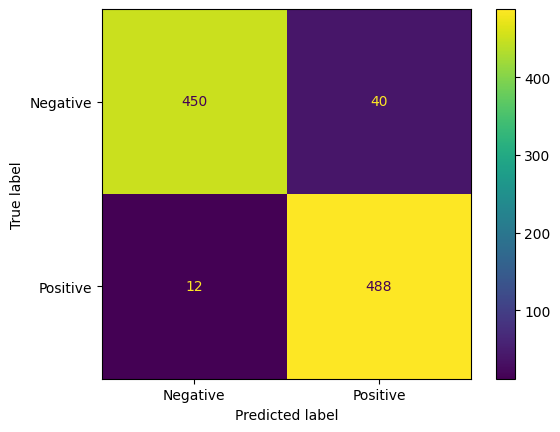

In [38]:
# Here I made the predictions on the test dataset using the trained model
test_predictions = trainer.predict(test_dataset)

# Here I converted the predictions into label indices by taking the argmax
pred_labels = test_predictions.predictions.argmax(-1)

# Here I assigned the predicted labels to a new column in the test dataframe
test_df['Predicted_Label'] = pred_labels

# Here I created a new column in the test dataframe that checks if the predicted label matches the true label
test_df['Correct'] = test_df['Label'] == test_df['Predicted_Label']

# Here I filtered the dataframe to include only the rows where the prediction was incorrect
misclassified = test_df[test_df['Correct'] == False]

# Here I displayed the columns 'Claim', 'Label', and 'Predicted_Label' from the misclassified examples
misclassified[['Statement', 'Label', 'Predicted_Label']]

# Save the misclassified claims into a dataframe
misclassified_df = misclassified[['Statement', 'Label', 'Predicted_Label']]

file_path = 'misclassified_claims_English_test.xlsx'
misclassified_df.to_excel(file_path, index=False)

print(f"File saved as {file_path}")

# Here I created a confusion matrix of the test set based on the results of the test set
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_df['Label'], test_df['Predicted_Label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot()

# Here I wanted to see which labels are misclassified
category_errors = misclassified.groupby('Category').size()
print(category_errors)

#Test_set_Telugu

In [39]:
#Here I loaded the Telugu test set
test_df = pd.read_excel("/content/Claim_Verification_Telugu_Test.xlsx")

In [40]:
len(test_df)

990

In [41]:
test_df.head()

,Statement,Label,Category
0,"""సాధారణ జలుబు"" కరోనావైరస్తో మునుపటి ఇన్ఫెక్షన్...",True,COVID-19
1,"కోవిడ్-19: రికవరీ రేటులో చండీగఢ్, పంజాబ్ ముందం...",True,COVID-19
2,"కోవిడ్‌తో ముగ్గురు మృతి చెందగా, రాజస్థాన్‌లో 2...",True,COVID-19
3,"భారతదేశం, ఆస్ట్రేలియా 2+2 సంభాషణను కలిగి ఉన్నా...",True,COVID-19
4,క‌రోనా వైర‌స్ వ్యాక్సిన్‌పై భార‌త్‌తో అత్యంత స...,True,COVID-19


In [42]:
test_df.tail()

,Statement,Label,Category
985,వాస్తవం తనిఖీ: ఎంపీలో పూజారిని కొట్టిన పోలీసు ...,Fake,VIOLENCE
986,వాస్తవ తనిఖీ: ఈ వీడియోలో మహిళలు 'రామ్ భజనలు' ప...,Fake,VIOLENCE
987,జనమ్ టీవీ కేరళ కాలేజీలో వార్షిక కార్యక్రమాలకు ...,Fake,VIOLENCE
988,స్పెయిన్‌లో ఆత్మహత్య చేసుకున్న తేదీ ఫోటోలు కరో...,Fake,VIOLENCE
989,"మార్చి 2019లో, ఢిల్లీలో 77% కంటే ఎక్కువ విలువై...",Fake,VIOLENCE


In [43]:
test_texts = list(test_df['Statement'])

In [44]:
test_df['Label'] = test_df['Label'].astype(str)

In [45]:
test_df['Label'] = le.fit_transform(test_df.Label.values)

In [46]:
test_labels = test_df['Label']

In [47]:
len(test_labels)

990

In [48]:
test_encodings = tokenizer(test_texts, truncation=True, padding=True)
test_dataset = Claim_verification_Dataset(test_encodings, test_labels)

In [49]:
test_metrics = trainer.evaluate(test_dataset)

In [50]:
print(test_metrics)

{'eval_loss': 0.2565496265888214, 'eval_Accuracy': 0.9191919191919192, 'eval_F1': 0.9191919191919192, 'eval_Precision': 0.9191919191919192, 'eval_Recall': 0.9191919191919192, 'eval_runtime': 2.5951, 'eval_samples_per_second': 381.493, 'eval_steps_per_second': 23.891, 'epoch': 0.8921330089213301}


#Error_analysis_Telugu

File saved as misclassified_claims_Telugu_test.xlsx
Category
COVID-19      16
ELECTION       9
GOVERNMENT    14
POLITICS      26
TRAD           7
VIOLENCE       8
dtype: int64


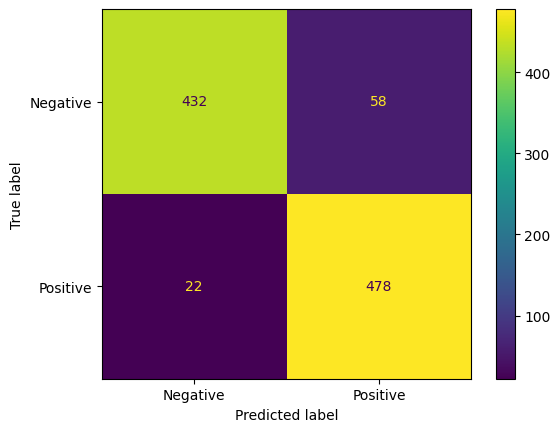

In [51]:
# Here I made the predictions on the test dataset using the trained model
test_predictions = trainer.predict(test_dataset)

# Here I converted the predictions into label indices by taking the argmax
pred_labels = test_predictions.predictions.argmax(-1)

# Here I assigned the predicted labels to a new column in the test dataframe
test_df['Predicted_Label'] = pred_labels

# Here I created a new column in the test dataframe that checks if the predicted label matches the true label
test_df['Correct'] = test_df['Label'] == test_df['Predicted_Label']

# Here I filtered the dataframe to include only the rows where the prediction was incorrect
misclassified = test_df[test_df['Correct'] == False]

# Here I displayed the columns 'Claim', 'Label', and 'Predicted_Label' from the misclassified examples
misclassified[['Statement', 'Label', 'Predicted_Label']]

# Save the misclassified claims into a dataframe
misclassified_df = misclassified[['Statement', 'Label', 'Predicted_Label']]

file_path = 'misclassified_claims_Telugu_test.xlsx'
misclassified_df.to_excel(file_path, index=False)

print(f"File saved as {file_path}")

# Here I created a confusion matrix of the test set based on the results of the test set
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_df['Label'], test_df['Predicted_Label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot()

# Here I wanted to see which labels are misclassified
category_errors = misclassified.groupby('Category').size()
print(category_errors)